# 4.4. Implementação de regressão Softmax do zero

Como a regressão softmax é tão fundamental, acreditamos que você deveria saber como implementá-la sozinho.

Aqui, nos limitamos a definir os aspectos específicos do modelo softmax e reutilizar os outros componentes de nossa seção de regressão linear, incluindo o ciclo de treinamento.

In [1]:
import torch
from d2l import torch as d2l

# 4.4.1. O Softmax

In [8]:
X = torch.tensor([[1.0, 2.0, 3.0], 
                  [4.0, 5.0, 6.0]])  # matriz
(X,
X.sum(0, keepdims=True),  # soma as colunas
X.sum(1, keepdims=True))   # soma as linhas

(tensor([[1., 2., 3.],
         [4., 5., 6.]]),
 tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

In [4]:
X.sum(0, keepdims=True), X.sum(1, keepdims=True)

(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

In [9]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdims=True)
    return X_exp / partition  # The broadcasting mechanism is applied here

Para qualquer entrada X, transformamos cada elemento em um número não negativo. Cada linha soma 1, conforme necessário para uma probabilidade. Cuidado: o código acima não é robusto contra argumentos muito grandes ou muito pequenos. As estruturas de aprendizado profundo têm essas proteções integradas e usaremos o softmax integrado daqui para frente.

In [18]:
X = torch.rand((2, 5))
print(X)
X_prob = softmax(X)
X_prob, X_prob.sum(1)   # O somatório de cada linha vale 1.

tensor([[0.6343, 0.8231, 0.3844, 0.7238, 0.8492],
        [0.0314, 0.7845, 0.4685, 0.8161, 0.8297]])


(tensor([[0.1880, 0.2270, 0.1464, 0.2056, 0.2330],
         [0.1101, 0.2337, 0.1704, 0.2412, 0.2445]]),
 tensor([1., 1.]))

# 4.4.2. O modelo

Como no nosso exemplo de regressão linear, cada instância será representada por um vetor de comprimento fixo. Como os dados brutos aqui consistem em
imagens de pixel, achatamos cada imagem, tratando-as como vetores de comprimento 784 (28x28=784).

Na regressão softmax, o número de saídas da nossa rede deve ser igual ao número de classes. Como nosso conjunto de dados possui 10 classes, nossa rede tem uma dimensão de saída de 10. 

Consequentemente, nossos pesos constituem um 784x10 matriz mais um 1x10 vetor linha para os bieses (b). 

Tal como acontece com a regressão linear, inicializamos os pesos W com ruído gaussiano. 

Os biases (b) são inicializadas como zeros.


In [22]:
#[O](1X10) = [X](1X784) . [W](784X10) + [B](1X10)
# 10 saídas (O), cada uma correspondendo a uma classe.
# 784 entradas (X), cada um correspondendo a um pixel, dos 28x28=784.

In [21]:
class SoftmaxRegressionScratch(d2l.Classifier):
    def __init__(self, num_inputs, num_outputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W = torch.normal(0, sigma, size=(num_inputs, num_outputs),
                              requires_grad=True)
        self.b = torch.zeros(num_outputs, requires_grad=True)

    def parameters(self):
        return [self.W, self.b]

O código abaixo define como a rede mapeia cada entrada para uma saída. Observe que achatamos cada 28x28 imagem de pixel do lote em um vetor usando reshape antes de passar os dados por nosso modelo.

In [25]:
@d2l.add_to_class(SoftmaxRegressionScratch)
def forward(self, X):
    X = X.reshape((-1, self.W.shape[0]))               # converte X em vetor linha: entrada X era 28x28 e agora é 1x784.
    return softmax(torch.matmul(X, self.W) + self.b)   # Softmax de: [O](1X10) = [X](1X784) . [W](784X10) + [B](1X10)

# 4.4.3. A perda de entropia cruzada

Esta pode ser a função de perda mais comum em todo o aprendizado profundo

Lembre-se de que a entropia cruzada assume a probabilidade logarítmica negativa da probabilidade prevista atribuída ao rótulo verdadeiro. Para maior eficiência, evitamos loops for do Python e, em vez disso, usamos indexação. Em particular, a codificação one-hot em y nos permite selecionar os termos correspondentes em y_hat.

Para ver isso em ação, criamos dados de amostra y_hat com 2 exemplos de probabilidades previstas em 3 classes e seus rótulos correspondentes y. Os rótulos corretos são 0 e 2 respectivamente (ou seja, a primeira e a terceira classes). Usando y como índices de probabilidades y_hat, podemos escolher os termos com eficiência.

In [28]:
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y]

tensor([0.1000, 0.5000])

Agora podemos implementar a função de perda de entropia cruzada calculando a média dos logaritmos das probabilidades selecionadas.

In [30]:
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[list(range(len(y_hat))), y]).mean()

cross_entropy(y_hat, y)

tensor(1.4979)

In [31]:
@d2l.add_to_class(SoftmaxRegressionScratch)
def loss(self, y_hat, y):
    return cross_entropy(y_hat, y)

# 4.4.4. Treinamento

Reutilizamos o fit método definido na Seção 3.4 para treinar o modelo com 10 épocas. Observe que o número de épocas (max_epochs), o tamanho do minilote (batch_size) e a taxa de aprendizado (lr) são hiperparâmetros ajustáveis. Isso significa que, embora esses valores não sejam aprendidos durante nosso ciclo de treinamento primário, eles ainda influenciam o desempenho de nosso modelo, tanto em relação ao treinamento quanto ao desempenho de generalização. 

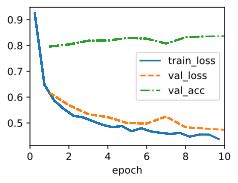

In [32]:
data = d2l.FashionMNIST(batch_size=256)
model = SoftmaxRegressionScratch(num_inputs=784, num_outputs=10, lr=0.1)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

# 4.4.5. Predição

Agora que o treinamento foi concluído, nosso modelo está pronto para classificar algumas imagens.

In [33]:
X, y = next(iter(data.val_dataloader()))
preds = model(X).argmax(axis=1)
preds.shape

torch.Size([256])

Estamos mais interessados nas imagens que rotulamos incorretamente . Nós os visualizamos comparando seus rótulos reais (primeira linha da saída de texto) com as previsões do modelo (segunda linha da saída de texto).

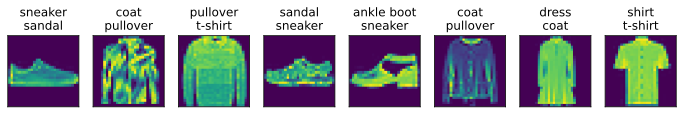

In [34]:
wrong = preds.type(y.dtype) != y
X, y, preds = X[wrong], y[wrong], preds[wrong]
labels = [a+'\n'+b for a, b in zip(
    data.text_labels(y), data.text_labels(preds))]
data.visualize([X, y], labels=labels)

# 4.4.6. Resumo

Agora estamos começando a adquirir alguma experiência na resolução de problemas de regressão linear e classificação. Com isso, alcançamos o que seria indiscutivelmente o estado da arte da modelagem estatística das décadas de 1960-1970.

# Código Agrupado

In [ ]:
import torch
from d2l import torch as d2l


def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdims=True)
    return X_exp / partition  # The broadcasting mechanism is applied here

def cross_entropy(y_hat, y):
    return -torch.log(y_hat[list(range(len(y_hat))), y]).mean()


class SoftmaxRegressionScratch(d2l.Classifier):
    def __init__(self, num_inputs, num_outputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W = torch.normal(0, sigma, size=(num_inputs, num_outputs),
                              requires_grad=True)
        self.b = torch.zeros(num_outputs, requires_grad=True)

    def parameters(self):
        return [self.W, self.b]

    def forward(self, X):
        X = X.reshape((-1, self.W.shape[0]))               # converte X em vetor linha: entrada X era 28x28 e agora é 1x784.
        return softmax(torch.matmul(X, self.W) + self.b)   # Softmax de: [O](1X10) = [X](1X784) . [W](784X10) + [B](1X10)

    def loss(self, y_hat, y):
        return cross_entropy(y_hat, y)





data = d2l.FashionMNIST(batch_size=256)
model = SoftmaxRegressionScratch(num_inputs=784, num_outputs=10, lr=0.1)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)


# -----------------------------------------------------------------------------------------------------------------------------
X, y = next(iter(data.val_dataloader()))
preds = model(X).argmax(axis=1)
preds.shape

wrong = preds.type(y.dtype) != y
X, y, preds = X[wrong], y[wrong], preds[wrong]
labels = [a+'\n'+b for a, b in zip(
    data.text_labels(y), data.text_labels(preds))]
data.visualize([X, y], labels=labels)




# CÓDIGO ALTERADO PARA RODAR NO PyCharm

ALTERANDO O CÓDIGO PARA ELIMINAR ERRO DE DATALOADER (DataLoader worker) AO RODAR NO PYCHARM: \
FAZER num_workers=0 NA CLASSE FashionMNIST. 

return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train, num_workers=0)

PARA NÃO ALTERAR A CLASSE ORIGINAL, COPIO A CLASSE AQUI.

In [ ]:
import torch
from d2l import torch as d2l
from torchvision import transforms
import torchvision

def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdims=True)
    return X_exp / partition  # The broadcasting mechanism is applied here

def cross_entropy(y_hat, y):
    return -torch.log(y_hat[list(range(len(y_hat))), y]).mean()


class SoftmaxRegressionScratch(d2l.Classifier):
    def __init__(self, num_inputs, num_outputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W = torch.normal(0, sigma, size=(num_inputs, num_outputs),
                              requires_grad=True)
        self.b = torch.zeros(num_outputs, requires_grad=True)

    def parameters(self):
        return [self.W, self.b]

    def forward(self, X):
        X = X.reshape((-1, self.W.shape[0]))               # converte X em vetor linha: entrada X era 28x28 e agora é 1x784.
        return softmax(torch.matmul(X, self.W) + self.b)   # Softmax de: [O](1X10) = [X](1X784) . [W](784X10) + [B](1X10)

    def loss(self, y_hat, y):
        return cross_entropy(y_hat, y)
# -----------------------------------------------------------------------------------------------------------------------------
# ALTERANDO O CÓDIGO PARA ELIMINAR ERRO DE DATALOADER AO RODAR NO PYCHARM:
# FAZER num_workers=0 NA CLASSE FashionMNIST.
#
# return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
#                                    num_workers=0)
#
# PARA NÃO ALTERAR A CLASSE ORIGINAL, COPIO A CLASSE AQUI.

class FashionMNIST(d2l.DataModule):
    """The Fashion-MNIST dataset.

    Defined in :numref:`sec_fashion_mnist`"""

    def __init__(self, batch_size=64, resize=(28, 28)):
        super().__init__()
        self.save_hyperparameters()
        trans = transforms.Compose([transforms.Resize(resize),
                                    transforms.ToTensor()])
        self.train = torchvision.datasets.FashionMNIST(
            root=self.root, train=True, transform=trans, download=True)
        self.val = torchvision.datasets.FashionMNIST(
            root=self.root, train=False, transform=trans, download=True)

    def text_labels(self, indices):
        """Return text labels.

        Defined in :numref:`sec_fashion_mnist`"""
        labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                  'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
        return [labels[int(i)] for i in indices]

    def get_dataloader(self, train):
        """Defined in :numref:`sec_fashion_mnist`"""
        data = self.train if train else self.val
        return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
                                           num_workers=0)

    def visualize(self, batch, nrows=1, ncols=8, labels=[]):
        """Defined in :numref:`sec_fashion_mnist`"""
        X, y = batch
        if not labels:
            labels = self.text_labels(y)
        d2l.show_images(X.squeeze(1), nrows, ncols, titles=labels)


# data = d2l.FashionMNIST(batch_size=256)
data = FashionMNIST(batch_size=256)           # Chamo a classe que está aqui e não a original.
# -----------------------------------------------------------------------------------------------------------------------------



model = SoftmaxRegressionScratch(num_inputs=784, num_outputs=10, lr=0.1)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)


# -----------------------------------------------------------------------------------------------------------------------------
X, y = next(iter(data.val_dataloader()))
preds = model(X).argmax(axis=1)
preds.shape

wrong = preds.type(y.dtype) != y
X, y, preds = X[wrong], y[wrong], preds[wrong]
labels = [a+'\n'+b for a, b in zip(
    data.text_labels(y), data.text_labels(preds))]
data.visualize([X, y], labels=labels)




# CÓDIGO ALTERADO PARA NÃO PLOTAR, APENAS IMPRIMIR OS DADOS.

In [1]:
import torch
from d2l import torch as d2l
from torchvision import transforms
import torchvision

def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdims=True)
    return X_exp / partition  # The broadcasting mechanism is applied here

def cross_entropy(y_hat, y):
    return -torch.log(y_hat[list(range(len(y_hat))), y]).mean()

# -------------------------------------------------------------------------------------
class Module(d2l.nn_Module, d2l.HyperParameters):
    """The base class of models.

    Defined in :numref:`sec_oo-design`"""
    def __init__(self, plot_train_per_epoch=2, plot_valid_per_epoch=1):
        super().__init__()
        self.save_hyperparameters()
        self.board = d2l.ProgressBoard()

    def loss(self, y_hat, y):
        raise NotImplementedError

    def forward(self, X):
        assert hasattr(self, 'net'), 'Neural network is defined'
        return self.net(X)

    def plot(self, key, value, train):
        """Plot a point in animation."""
        assert hasattr(self, 'trainer'), 'Trainer is not inited'
        # self.board.xlabel = 'epoch'
        if train:
            x = self.trainer.train_batch_idx / \
                self.trainer.num_train_batches
            n = self.trainer.num_train_batches / \
                self.plot_train_per_epoch
        else:
            x = self.trainer.epoch + 1
            n = self.trainer.num_val_batches / \
                self.plot_valid_per_epoch
        # self.board.draw(x, d2l.numpy(d2l.to(value, d2l.cpu())),
        #                 ('train_' if train else 'val_') + key,
        #                 every_n=int(n))

    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        # self.plot('loss', l, train=True)
        print(f'train_loss: {l}')
        return l

    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        # self.plot('loss', l, train=False)
        print(f'val1_loss: {l}')


    def configure_optimizers(self):
        raise NotImplementedError

    def configure_optimizers(self):
        """Defined in :numref:`sec_classification`"""
        return torch.optim.SGD(self.parameters(), lr=self.lr)

    def apply_init(self, inputs, init=None):
        """Defined in :numref:`sec_lazy_init`"""
        self.forward(*inputs)
        if init is not None:
            self.net.apply(init)



# -----------------------------------------------------------------------------------
class Classifier(Module):
    """The base class of classification models.

    Defined in :numref:`sec_classification`"""

    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        # self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)
        print(f'val_loss: {self.loss(Y_hat, batch[-1])}')
        # self.plot('acc', self.accuracy(Y_hat, batch[-1]), train=False)
        print(f'val_acc: {self.accuracy(Y_hat, batch[-1])}\n')

    def accuracy(self, Y_hat, Y, averaged=True):
        """Compute the number of correct predictions.

        Defined in :numref:`sec_classification`"""
        Y_hat = d2l.reshape(Y_hat, (-1, Y_hat.shape[-1]))
        preds = d2l.astype(d2l.argmax(Y_hat, axis=1), Y.dtype)
        compare = d2l.astype(preds == d2l.reshape(Y, -1), d2l.float32)
        return d2l.reduce_mean(compare) if averaged else compare

    def loss(self, Y_hat, Y, averaged=True):
        """Defined in :numref:`sec_softmax_concise`"""
        Y_hat = d2l.reshape(Y_hat, (-1, Y_hat.shape[-1]))
        Y = d2l.reshape(Y, (-1,))
        return F.cross_entropy(
            Y_hat, Y, reduction='mean' if averaged else 'none')

    def layer_summary(self, X_shape):
        """Defined in :numref:`sec_lenet`"""
        X = d2l.randn(*X_shape)
        for layer in self.net:
            X = layer(X)
            print(layer.__class__.__name__, 'output shape:\t', X.shape)




# ---------------------------------------------------------------------------------
class SoftmaxRegressionScratch(Classifier):
    def __init__(self, num_inputs, num_outputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W = torch.normal(0, sigma, size=(num_inputs, num_outputs),
                              requires_grad=True)
        self.b = torch.zeros(num_outputs, requires_grad=True)

    def parameters(self):
        return [self.W, self.b]

    def forward(self, X):
        X = X.reshape((-1, self.W.shape[0]))               # converte X em vetor linha: entrada X era 28x28 e agora é 1x784.
        return softmax(torch.matmul(X, self.W) + self.b)   # Softmax de: [O](1X10) = [X](1X784) . [W](784X10) + [B](1X10)

    def loss(self, y_hat, y):
        return cross_entropy(y_hat, y)
# -----------------------------------------------------------------------------------------------------------------------------
# ALTERANDO O CÓDIGO PARA ELIMINAR ERRO DE DATALOADER AO RODAR NO PYCHARM:
# FAZER num_workers=0 NA CLASSE FashionMNIST.
#
# return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
#                                    num_workers=0)
#
# PARA NÃO ALTERAR A CLASSE ORIGINAL, COPIO A CLASSE AQUI.

class FashionMNIST(d2l.DataModule):
    """The Fashion-MNIST dataset.

    Defined in :numref:`sec_fashion_mnist`"""

    def __init__(self, batch_size=64, resize=(28, 28)):
        super().__init__()
        self.save_hyperparameters()
        trans = transforms.Compose([transforms.Resize(resize),
                                    transforms.ToTensor()])
        self.train = torchvision.datasets.FashionMNIST(
            root=self.root, train=True, transform=trans, download=True)
        self.val = torchvision.datasets.FashionMNIST(
            root=self.root, train=False, transform=trans, download=True)

    def text_labels(self, indices):
        """Return text labels.

        Defined in :numref:`sec_fashion_mnist`"""
        labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                  'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
        return [labels[int(i)] for i in indices]

    def get_dataloader(self, train):
        """Defined in :numref:`sec_fashion_mnist`"""
        data = self.train if train else self.val
        return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
                                           num_workers=0)

    def visualize(self, batch, nrows=1, ncols=8, labels=[]):
        """Defined in :numref:`sec_fashion_mnist`"""
        X, y = batch
        if not labels:
            labels = self.text_labels(y)
        d2l.show_images(X.squeeze(1), nrows, ncols, titles=labels)


# -----------------------------------------------------------------------------------------------------------------------------




# -----------------------------------------------------------------------------------------------------------------------------
# data = d2l.FashionMNIST(batch_size=256)
data = FashionMNIST(batch_size=256)           # Chamo a classe que está aqui e não a original.


model = SoftmaxRegressionScratch(num_inputs=784, num_outputs=10, lr=0.1)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)


# -----------------------------------------------------------------------------------------------------------------------------
X, y = next(iter(data.val_dataloader()))
preds = model(X).argmax(axis=1)
preds.shape

# wrong = preds.type(y.dtype) != y
# X, y, preds = X[wrong], y[wrong], preds[wrong]
# labels = [a+'\n'+b for a, b in zip(
#     data.text_labels(y), data.text_labels(preds))]
# data.visualize([X, y], labels=labels)




train_loss: 2.331815481185913
train_loss: 2.122681140899658
train_loss: 1.9817062616348267
train_loss: 1.8448574542999268
train_loss: 1.7178820371627808
train_loss: 1.6343004703521729
train_loss: 1.5329409837722778
train_loss: 1.476838231086731
train_loss: 1.4014641046524048
train_loss: 1.426507592201233
train_loss: 1.335477590560913
train_loss: 1.3228278160095215
train_loss: 1.2300997972488403
train_loss: 1.1915150880813599
train_loss: 1.173330307006836
train_loss: 1.1573013067245483
train_loss: 1.1521072387695312
train_loss: 1.1781456470489502
train_loss: 1.0535671710968018
train_loss: 1.1012922525405884
train_loss: 1.069714069366455
train_loss: 1.0418416261672974
train_loss: 1.0471009016036987
train_loss: 1.0684865713119507
train_loss: 1.04365074634552
train_loss: 0.9935818910598755
train_loss: 0.9560199975967407
train_loss: 0.9587420225143433
train_loss: 1.0027835369110107
train_loss: 0.9747763872146606
train_loss: 1.0069963932037354
train_loss: 0.9695148468017578
train_loss: 0.947

torch.Size([256])

Outra opção é alterar apenas as funções específicas dentro da classe e modificá-las usando o decorator:

@d2l.add_to_class(d2l.Classe_Base)

Assim, não é preciso trazer a classe inteira, mas apenas a função específica alterada.

__CUIDADO:__ É preciso verificar se o código está se comportando conforme o esperado. 
A d2l.Classe_Base deve ser a Classe na qual a função está inserida, mesmo que esta tenha uma classe base interna.
Fazendo isto, o código se comporta conforme esperado.

__VANTAGEM__: Utilizando decorator(@), não são necessárias alterações no restante do código (chamamento das classes), diferente do que ocorre quando copia-se a classe inteira, onde ao invés de chamar _d2l.Classe_copiada_, chama-se apenas _Classe_copiada_.

# Exercícios

# Ex. 1.1

1. Nesta seção, implementamos diretamente a função softmax com base na definição matemática da operação softmax. Conforme discutido na Seção 4.1, isso pode causar instabilidades numéricas.

1.1-Teste se softmax ainda funciona corretamente se uma entrada tiver um valor de 100.


In [53]:
import torch
from d2l import torch as d2l

X1 = torch.tensor([[1,2,8,15]])

X_exp = torch.exp(X1)
partition = X_exp.sum(1, keepdims=True)
softmax = X_exp / partition  # The broadcasting mechanism is applied here
print(softmax)
print(torch.sum(softmax))

# ------------------------------------------------------------------------------------

X2 = torch.tensor([[1,2,8,100]])   # Neste caso, softmax não funciona corretamente.

X_exp = torch.exp(X2)
partition = X_exp.sum(1, keepdims=True)
softmax = X_exp / partition  # The broadcasting mechanism is applied here
print(softmax)
torch.sum(softmax)

tensor([[8.3077e-07, 2.2583e-06, 9.1105e-04, 9.9909e-01]])
tensor(1.)
tensor([[0., 0., 0., nan]])


tensor(nan)

Portanto, para uma entrada igual a 110, softmax não funciona corretamente.

# Ex. 1.2
1.2 - Teste se softmax ainda funciona corretamente se a maior de todas as entradas for menor que -100?

In [58]:
import torch
from d2l import torch as d2l

X1 = torch.tensor([[1,2,8,15]])

X_exp = torch.exp(X1)
partition = X_exp.sum(1, keepdims=True)
softmax = X_exp / partition  # The broadcasting mechanism is applied here
print(softmax)
print(torch.sum(softmax))

# ------------------------------------------------------------------------------------

X2 = torch.tensor([[1,2,8,-110]])       # Neste caso, softmax funciona corretamente.

X_exp = torch.exp(X2)
partition = X_exp.sum(1, keepdims=True)
softmax = X_exp / partition  # The broadcasting mechanism is applied here
print(softmax)
torch.sum(softmax)

tensor([[8.3077e-07, 2.2583e-06, 9.1105e-04, 9.9909e-01]])
tensor(1.)
tensor([[9.0880e-04, 2.4704e-03, 9.9662e-01, 0.0000e+00]])


tensor(1.0000)

Portanto, para uma entrada igual a - 110, softmax funciona corretamente.

# Ex. 1.3 
Implemente uma correção observando o valor relativo à maior entrada no argumento.

In [73]:
import torch
import numpy as np
from d2l import torch as d2l

X = torch.tensor([[1,2,30,90]])    # limite: 80

X_exp = torch.exp(X)
partition = X_exp.sum(1, keepdims=True)
softmax = X_exp / partition  # The broadcasting mechanism is applied here
print(softmax)
print(torch.sum(softmax))    # Somatório = infinito, ao invés de 1.

# Correção:
for i in range(0,X.shape[1]):
    # if X[0][i] > 80:
    if X_exp[0][i] == torch.tensor([[np.inf]]):
        softmax[0][i] = 1

print(softmax)
print(torch.sum(softmax))    # Somatório = 1.


tensor([[0., 0., 0., nan]])
tensor(nan)
tensor([[0., 0., 0., 1.]])
tensor(1.)


# Ex. 2.

Implemente uma cross_entropy função que siga a definição da função de perda de entropia cruzada.

In [77]:
import torch
import numpy as np
from d2l import torch as d2l

def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdims=True)
    softmax = X_exp / partition  # The broadcasting mechanism is applied here

    # Correção:
    for i in range(0,X.shape[1]):
        # if X[0][i] > 80:
        if X_exp[0][i] == torch.tensor([[np.inf]]):
            softmax[0][i] = 1

    # print(softmax)
    # print(torch.sum(softmax))

    return softmax

# -----------------------------------------------------------
def cross_entropy(y,y_hat):
    l = torch.zeros(y_hat.shape[1])  # inicializa l como um vetor de zeros.
    for i in range(0,y_hat.shape[1]):
        l[i] = y[0,i] * torch.log(y_hat[0,i])  # substitui os elementos de l
    l_end = -torch.sum(l)
    return l_end

# -----------------------------------------------------------
X = torch.tensor([[1,2,3,15]])    # limite: 80
y_hat = softmax(X)
y = y_hat*1.015
soma = torch.sum(y_hat)
entropy = cross_entropy(y,y_hat)

print(y_hat)
print(soma)
print(entropy)


tensor([[8.3152e-07, 2.2603e-06, 6.1442e-06, 9.9999e-01]])
tensor(1.)
tensor(0.0001)


In [96]:
# https://pandalab.me/archives/softmax_regression_implementation_from_scratch:

def cross_entropy_def(y_hat, y):
    l = torch.matmul(y.type(torch.float32),torch.log(y_hat))
    return print(l), l.mean()

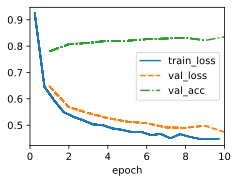

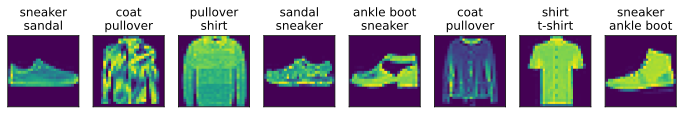

In [95]:
import torch
from d2l import torch as d2l


# def softmax(X):
#     X_exp = torch.exp(X)
#     partition = X_exp.sum(1, keepdims=True)
#     return X_exp / partition  # The broadcasting mechanism is applied here
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdims=True)
    softmax = X_exp / partition  # The broadcasting mechanism is applied here

    # Correção:
    for i in range(0,X.shape[1]):
        # if X[0][i] > 80:
        if X_exp[0][i] == torch.tensor([[np.inf]]):
            softmax[0][i] = 1
    # print(softmax)
    # print(torch.sum(softmax))
    return softmax


# def cross_entropy(y_hat, y):
#     return -torch.log(y_hat[list(range(len(y_hat))), y]).mean()

def cross_entropy_def(y_hat, y):
    l = torch.matmul(y.type(torch.float32),torch.log(y_hat))
    return print(l), l.mean()

# def cross_entropy(y,y_hat):
#     l = torch.zeros(y_hat.shape[0])  # inicializa l como um vetor de zeros.
#     for i in range(0,y_hat.shape[0]):
#         l[i] = y[i] * torch.log(y_hat[0,i])  # substitui os elementos de l
#     l_end = -torch.sum(l)
#     return l_end




class SoftmaxRegressionScratch(d2l.Classifier):
    def __init__(self, num_inputs, num_outputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W = torch.normal(0, sigma, size=(num_inputs, num_outputs),
                              requires_grad=True)
        self.b = torch.zeros(num_outputs, requires_grad=True)

    def parameters(self):
        return [self.W, self.b]

    def forward(self, X):
        X = X.reshape((-1, self.W.shape[0]))               # converte X em vetor linha: entrada X era 28x28 e agora é 1x784.
        return softmax(torch.matmul(X, self.W) + self.b)   # Softmax de: [O](1X10) = [X](1X784) . [W](784X10) + [B](1X10)

    def loss(self, y_hat, y):
        return cross_entropy(y_hat, y)





data = d2l.FashionMNIST(batch_size=256)
model = SoftmaxRegressionScratch(num_inputs=784, num_outputs=10, lr=0.1)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)


# -----------------------------------------------------------------------------------------------------------------------------
X, y = next(iter(data.val_dataloader()))
preds = model(X).argmax(axis=1)
preds.shape

wrong = preds.type(y.dtype) != y
X, y, preds = X[wrong], y[wrong], preds[wrong]
labels = [a+'\n'+b for a, b in zip(
    data.text_labels(y), data.text_labels(preds))]
data.visualize([X, y], labels=labels)


